# MUSA550 - Assignment 6: Predictive Modeling of Housing Prices in Philadelphia

**Due date: Wednesday, 12/6 by the end of the day**


Lectures 12B and 13A will cover predictive modeling of housing prices in Philadelphia. We'll extend that analysis in this section by:

- Optimizing our hyperparameters during the modeling process using cross-validation and a grid search
- Testing the fairness of our model by calculating the intersection of the model error rate and poverty rate across neighborhoods

### Hang Zhao

## Part 2: Modeling Philadelphia's Housing Prices and Algorithmic Fairness


### 2.1 Load data from the Office of Property Assessment

Use the requests package to query the CARTO API for **single-family** property assessment data in Philadelphia for properties that had their **last sale during 2022**.

Sources: 
- [OpenDataPhilly](https://www.opendataphilly.org/dataset/opa-property-assessments)
- [Metadata](http://metadata.phila.gov/#home/datasetdetails/5543865f20583086178c4ee5/representationdetails/55d624fdad35c7e854cb21a4/)

In [1]:
import geopandas as gpd
import requests

In [2]:
# the CARTO API url
carto_url = "https://phl.carto.com/api/v2/sql"

# Only pull 2022 sales for single family residential properties
where = "sale_date >= '2022-01-01' and sale_date <= '2022-12-31'"
where = where + " and category_code_description IN ('SINGLE FAMILY', 'Single Family')"

# Create the query
query = f"SELECT * FROM opa_properties_public WHERE {where}"

# Make the request
params = {"q": query, "format": "geojson"}
response = requests.get(carto_url, params=params)

In [3]:
response

<Response [200]>

In [4]:
# Make the GeoDataFrame
salesRaw = gpd.GeoDataFrame.from_features(response.json(), crs="EPSG:4326")

# Optional: put it a reproducible order for test/training splits later
salesRaw = salesRaw.sort_values("parcel_number")

In [5]:
salesRaw.head(n=5)

,geometry,cartodb_id,assessment_date,basements,beginning_point,book_and_page,building_code,building_code_description,category_code,category_code_description,...,utility,view_type,year_built,year_built_estimate,zip_code,zoning,pin,building_code_new,building_code_description_new,objectid
919,POINT (-75.14860 39.93145),18102,2022-05-24T00:00:00Z,0,"36'6"" E OF AMERICAN",54131081,R30,ROW B/GAR 2 STY MASONRY,1,SINGLE FAMILY,...,None,I,1960,Y,19147,RSA5,1001563093,26,ROW RIVER ROW,401690820
12802,POINT (-75.14817 39.93101),32924,2022-05-24T00:00:00Z,A,50' W SIDE OF 2ND ST,54063610,O50,ROW 3 STY MASONRY,1,SINGLE FAMILY,...,None,I,2009,None,19147,RSA5,1001190209,22,ROW TYPICAL,401704018
9020,POINT (-75.14781 39.93010),28224,2022-05-24T00:00:00Z,A,33.333 S OF REED,54085418,P51,ROW W/GAR 3 STY MAS+OTHER,1,SINGLE FAMILY,...,None,I,2014,None,19147,ICMX,1001442221,25,ROW MODERN,401699421
1344,POINT (-75.14887 39.93026),18517,2022-05-24T00:00:00Z,D,68 FT W PHILIP ST,54127951,O50,ROW 3 STY MASONRY,1,SINGLE FAMILY,...,None,I,1920,Y,19147,RSA5,1001442236,22,ROW TYPICAL,401691319
12767,POINT (-75.14881 39.93012),32882,2022-05-24T00:00:00Z,D,42 FT W PHILIP,54063384,O30,ROW 2 STY MASONRY,1,SINGLE FAMILY,...,None,I,1920,Y,19147,RSA5,1001238775,22,ROW TYPICAL,401704228


### 2.2 Load data for census tracts and neighborhoods

Load various Philadelphia-based regions that we will use in our analysis. 

- Census tracts can be downloaded from: [https://opendata.arcgis.com/datasets/8bc0786524a4486bb3cf0f9862ad0fbf_0.geojson](https://opendata.arcgis.com/datasets/8bc0786524a4486bb3cf0f9862ad0fbf_0.geojson)
- Neighborhoods can be downloaded from:
[https://raw.githubusercontent.com/azavea/geo-data/master/Neighborhoods_Philadelphia/Neighborhoods_Philadelphia.geojson](https://raw.githubusercontent.com/azavea/geo-data/master/Neighborhoods_Philadelphia/Neighborhoods_Philadelphia.geojson)


In [7]:
# Get the data
url = "https://opendata.arcgis.com/datasets/8bc0786524a4486bb3cf0f9862ad0fbf_0.geojson"
Census_tract = gpd.read_file(url)
url2 = "https://raw.githubusercontent.com/azavea/geo-data/master/Neighborhoods_Philadelphia/Neighborhoods_Philadelphia.geojson"
Neighbor = gpd.read_file(url2)

In [8]:
Census_tract.head(n=5)

,OBJECTID,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,LOGRECNO,geometry
0,1,42,101,009400,42101009400,94,Census Tract 94,G5020,S,366717,0,+39.9632709,-075.2322437,10429,"POLYGON ((-75.22927 39.96054, -75.22865 39.960..."
1,2,42,101,009500,42101009500,95,Census Tract 95,G5020,S,319070,0,+39.9658709,-075.2379140,10430,"POLYGON ((-75.23536 39.96852, -75.23545 39.969..."
2,3,42,101,009600,42101009600,96,Census Tract 96,G5020,S,405273,0,+39.9655396,-075.2435075,10431,"POLYGON ((-75.24343 39.96230, -75.24339 39.962..."
3,4,42,101,013800,42101013800,138,Census Tract 138,G5020,S,341256,0,+39.9764504,-075.1771771,10468,"POLYGON ((-75.17341 39.97779, -75.17386 39.977..."
4,5,42,101,013900,42101013900,139,Census Tract 139,G5020,S,562934,0,+39.9750563,-075.1711846,10469,"POLYGON ((-75.17313 39.97776, -75.17321 39.977..."


In [9]:
Neighbor.head(n=5)

,name,listname,mapname,shape_leng,shape_area,cartodb_id,created_at,updated_at,geometry
0,PENNYPACK_PARK,Pennypack Park,Pennypack Park,87084.285589,6.014076e+07,9,2013-03-19 17:41:50.508000+00:00,2013-03-19 17:41:50.743000+00:00,"MULTIPOLYGON (((-75.05645 40.08743, -75.05667 ..."
1,OVERBROOK,Overbrook,Overbrook,57004.924607,7.692499e+07,138,2013-03-19 17:41:50.508000+00:00,2013-03-19 17:41:50.743000+00:00,"MULTIPOLYGON (((-75.22719 39.97740, -75.22984 ..."
2,GERMANTOWN_SOUTHWEST,"Germantown, Southwest",Southwest Germantown,14880.743608,1.441867e+07,59,2013-03-19 17:41:50.508000+00:00,2013-03-19 17:41:50.743000+00:00,"MULTIPOLYGON (((-75.16208 40.02829, -75.16145 ..."
3,EAST_PARKSIDE,East Parkside,East Parkside,10885.781535,4.231000e+06,129,2013-03-19 17:41:50.508000+00:00,2013-03-19 17:41:50.743000+00:00,"MULTIPOLYGON (((-75.19931 39.97462, -75.19869 ..."
4,GERMANY_HILL,Germany Hill,Germany Hill,13041.939087,6.949968e+06,49,2013-03-19 17:41:50.508000+00:00,2013-03-19 17:41:50.743000+00:00,"MULTIPOLYGON (((-75.22722 40.03523, -75.22865 ..."


### 2.3 Spatially join the sales data and neighborhoods/census tracts.

Perform a spatial join, such that each sale has an associated neighborhood and census tract.

**Note:** After performing the first spatial join, you will need to use the `drop()` function to remove the `index_right` column; otherwise an error will be raised on the second spatial join about duplicate columns.

In [10]:
Sjoin1 = gpd.sjoin(
    salesRaw,  
    Neighbor.to_crs(salesRaw.crs),  # The neighborhoods (in the same CRS)
    predicate="within",
    how="left",
)
Sjoin1=Sjoin1.drop(columns='index_right')

In [11]:
Sjoin = gpd.sjoin(
    Sjoin1,  # The point data for 311 tickets
    Census_tract.to_crs(Sjoin1.crs),  # The neighborhoods (in the same CRS)
    predicate="within",
    how="left",
)
Sjoin.head()

,geometry,cartodb_id_left,assessment_date,basements,beginning_point,book_and_page,building_code,building_code_description,category_code,category_code_description,...,GEOID10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,LOGRECNO
919,POINT (-75.14860 39.93145),18102,2022-05-24T00:00:00Z,0,"36'6"" E OF AMERICAN",54131081,R30,ROW B/GAR 2 STY MASONRY,1,SINGLE FAMILY,...,42101002702,27.02,Census Tract 27.02,G5020,S,367673.0,0.0,+39.9280114,-075.1495606,10368
12802,POINT (-75.14817 39.93101),32924,2022-05-24T00:00:00Z,A,50' W SIDE OF 2ND ST,54063610,O50,ROW 3 STY MASONRY,1,SINGLE FAMILY,...,42101002702,27.02,Census Tract 27.02,G5020,S,367673.0,0.0,+39.9280114,-075.1495606,10368
9020,POINT (-75.14781 39.93010),28224,2022-05-24T00:00:00Z,A,33.333 S OF REED,54085418,P51,ROW W/GAR 3 STY MAS+OTHER,1,SINGLE FAMILY,...,42101002702,27.02,Census Tract 27.02,G5020,S,367673.0,0.0,+39.9280114,-075.1495606,10368
1344,POINT (-75.14887 39.93026),18517,2022-05-24T00:00:00Z,D,68 FT W PHILIP ST,54127951,O50,ROW 3 STY MASONRY,1,SINGLE FAMILY,...,42101002702,27.02,Census Tract 27.02,G5020,S,367673.0,0.0,+39.9280114,-075.1495606,10368
12767,POINT (-75.14881 39.93012),32882,2022-05-24T00:00:00Z,D,42 FT W PHILIP,54063384,O30,ROW 2 STY MASONRY,1,SINGLE FAMILY,...,42101002702,27.02,Census Tract 27.02,G5020,S,367673.0,0.0,+39.9280114,-075.1495606,10368


In [12]:
#Sjoin.columns.values

array(['geometry', 'cartodb_id_left', 'assessment_date', 'basements',
       'beginning_point', 'book_and_page', 'building_code',
       'building_code_description', 'category_code',
       'category_code_description', 'census_tract', 'central_air',
       'cross_reference', 'date_exterior_condition', 'depth',
       'exempt_building', 'exempt_land', 'exterior_condition',
       'fireplaces', 'frontage', 'fuel', 'garage_spaces', 'garage_type',
       'general_construction', 'geographic_ward', 'homestead_exemption',
       'house_extension', 'house_number', 'interior_condition',
       'location', 'mailing_address_1', 'mailing_address_2',
       'mailing_care_of', 'mailing_city_state', 'mailing_street',
       'mailing_zip', 'market_value', 'market_value_date',
       'number_of_bathrooms', 'number_of_bedrooms', 'number_of_rooms',
       'number_stories', 'off_street_open', 'other_building', 'owner_1',
       'owner_2', 'parcel_number', 'parcel_shape', 'quality_grade',
       'recording

### 2.4 Train a Random Forest on the sales data

In this step, you should follow the steps outlined in lecture to preprocess and train your model. We'll extend our analysis to do a hyperparameter grid search to find the best model configuration. As you train your model, follow the following steps:

**Preprocessing Requirements**
- Trim the sales data to those sales with prices between $3,000 and $1 million
- Set up a pipeline that includes both numerical columns and categorical columns
- Include one-hot encoded variable for the *neighborhood* of the sale, **instead of ZIP code**. We don't want to include multiple location based categories, since they encode much of the same information.

**Training requirements**
- Use a 70/30% training/test split and predict the log of the sales price.
- Use GridSearchCV to perform a k-fold cross validation that optimize *at least 2* hyperparameters of the RandomForestRegressor
- After fitting your model and finding the optimal hyperparameters, you should evaluate the score (R-squared) on the test set (the original 30% sample withheld)

**Note**: You don't need to include additional features (such as spatial distance features) or perform any extra feature engineering beyond what is required above to receive full credit. Of course, you are always welcome to experiment!

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [14]:
np.random.seed(42)

In [15]:
# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Model selection
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Pipelines
from sklearn.pipeline import make_pipeline

# Preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [16]:
# The feature columns we want to use
cols = [
    "sale_price",
    "total_livable_area",
    "total_area",
    "garage_spaces",
    "fireplaces",
    "number_of_bathrooms",
    "number_of_bedrooms",
    "number_stories",
    "exterior_condition",
    "zip_code",
    "name",
]

# Trim to these columns and remove NaNs
sales = Sjoin[cols + ["geometry"]].dropna()

# Trim zip code to only the first five digits
sales["zip_code"] = sales["zip_code"].astype(str).str.slice(0, 5)

In [17]:
# Trim very low and very high sales
trim = (sales['sale_price'] > 3000) & (sales['sale_price'] < 1e6)
sales = sales.loc[trim]

In [18]:
len(sales)

17670

## Numerical Data

In [19]:
# Split the data 70/30
train_set, test_set = train_test_split(sales, test_size=0.3, random_state=42)

In [20]:
# the target labels: log of sale price
y_train = np.log(train_set["sale_price"])
y_test = np.log(test_set["sale_price"])

In [21]:
# The features
feature_cols = [
    "total_livable_area",
    "total_area",
    "garage_spaces",
    "fireplaces",
    "number_of_bathrooms",
    "number_of_bedrooms",
    "number_stories",
]
X_train = train_set[feature_cols].values
X_test = test_set[feature_cols].values

In [22]:
# Make a linear model pipeline
linear_pipeline = make_pipeline(StandardScaler(), LinearRegression())

# Fit on the training data
linear_pipeline.fit(X_train, y_train)

# What's the test score?
linear_pipeline.score(X_test, y_test)

0.18386976167249158

### Forest Pipeline

In [23]:
# Make a random forest pipeline
forest_pipeline = make_pipeline(
    StandardScaler(), RandomForestRegressor(n_estimators=100, random_state=42)
)

# Run the 10-fold cross validation
scores = cross_val_score(
    forest_pipeline,
    X_train,
    y_train,
    cv=10,
)

# Report
print("R^2 scores = ", scores)
print("Scores mean = ", scores.mean())
print("Score std dev = ", scores.std())

R^2 scores =  [0.3171259  0.30563743 0.3867302  0.37449741 0.32894432 0.30532346
 0.30151491 0.29504504 0.29748476 0.23596602]
Scores mean =  0.3148269433933536
Score std dev =  0.040247139415635486


In [24]:
# Fit on the training data
forest_pipeline.fit(X_train, y_train)

# What's the test score?
forest_pipeline.score(X_test, y_test)

0.33764330237438755

## Include the Categorical Data

In [25]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [26]:
# Numerical columns
num_cols = [
    "total_livable_area",
    "total_area",
    "garage_spaces",
    "fireplaces",
    "number_of_bathrooms",
    "number_of_bedrooms",
    "number_stories",
]

# Categorical columns
cat_cols = ["exterior_condition", "name"]

In [27]:
# Set up the column transformer with two transformers
# ----> Scale the numerical columns
# ----> One-hot encode the categorical columns

transformer = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

In [28]:
# Initialize the pipeline
# NOTE: only use 10 estimators here so it will run in a reasonable time
pipe = make_pipeline(
    transformer, RandomForestRegressor(n_estimators=10, 
                                       random_state=42)
)

In [29]:
# Fit the training set
pipe.fit(train_set, y_train);

In [30]:
# What's the test score?
pipe.score(test_set, y_test)

0.5313982409697242

## Graphing the Importance of "Neighbor" Info

In [ ]:
transformer

In [ ]:
# The steps in the column transformer
transformer.named_transformers_

In [ ]:
# The one-hot step
ohe = transformer.named_transformers_['cat']

ohe

In [ ]:
# One column for each category type!
ohe_cols = ohe.get_feature_names_out()

ohe_cols

In [ ]:
# Full list of columns is numerical + one-hot 
features = num_cols + list(ohe_cols)

features

In [ ]:
random_forest = pipe["randomforestregressor"]

# Create the dataframe with importances
importance = pd.DataFrame(
    {"Feature": features, "Importance": random_forest.feature_importances_}
)

In [ ]:
importance.head(n=20)

In [ ]:
import hvplot.pandas
# Sort by importance and get the top 30
# SORT IN DESCENDING ORDER
importance = importance.sort_values("Importance", ascending=False).iloc[:30]

# Plot
importance.hvplot.barh(x="Feature", y="Importance", height=700, flip_yaxis=True)

## K-fold Cross Validation

In [31]:
pipe.named_steps

{'columntransformer': ColumnTransformer(transformers=[('num', StandardScaler(),
                                  ['total_livable_area', 'total_area',
                                   'garage_spaces', 'fireplaces',
                                   'number_of_bathrooms', 'number_of_bedrooms',
                                   'number_stories']),
                                 ('cat', OneHotEncoder(handle_unknown='ignore'),
                                  ['exterior_condition', 'name'])]),
 'randomforestregressor': RandomForestRegressor(n_estimators=10, random_state=42)}

In [32]:
model_step = "randomforestregressor"
param_grid = {
    f"{model_step}__n_estimators": [5, 10, 15, 20, 30, 50, 100, 200],
    f"{model_step}__max_depth": [2, 5, 7, 9, 13, 21, 33, 51],
}

param_grid

{'randomforestregressor__n_estimators': [5, 10, 15, 20, 30, 50, 100, 200],
 'randomforestregressor__max_depth': [2, 5, 7, 9, 13, 21, 33, 51]}

In [33]:
# Run the 3-fold cross validation
scores = cross_val_score(
    forest_pipeline,
    X_train,
    y_train,
    cv=3,
)

# Report
print("R^2 scores = ", scores)
print("Scores mean = ", scores.mean())
print("Score std dev = ", scores.std())

R^2 scores =  [0.31247274 0.30460143 0.29103723]
Scores mean =  0.30270379808763737
Score std dev =  0.008853286714194464


In [34]:
# Create the grid and use 3-fold CV
grid_pipe = GridSearchCV(pipe, param_grid, cv=3, verbose=1)

# Run the search
grid_pipe.fit(train_set, y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['total_livable_area',
                                                                          'total_area',
                                                                          'garage_spaces',
                                                                          'fireplaces',
                                                                          'number_of_bathrooms',
                                                                          'number_of_bedrooms',
                                                                          'number_stories']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['exterior_condition',
                                                                          'name'])])),
                                       ('randomforestregressor',
                                        RandomForestRegressor(n_estimators=10,
                                                              random_state=42))]),
             param_grid={'randomforestregressor__max_depth': [2, 5, 7, 9, 13,
                                                              21, 33, 51],
                         'randomforestregressor__n_estimators': [5, 10, 15, 20,
                                                                 30, 50, 100,
                                                                 200]},
             verbose=1)

In [35]:
grid_pipe.best_estimator_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['total_livable_area',
                                                   'total_area',
                                                   'garage_spaces',
                                                   'fireplaces',
                                                   'number_of_bathrooms',
                                                   'number_of_bedrooms',
                                                   'number_stories']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['exterior_condition',
                                                   'name'])])),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=33, n_estimators=200,
                                       random_state=42))])

In [36]:
grid_pipe.best_params_

{'randomforestregressor__max_depth': 33,
 'randomforestregressor__n_estimators': 200}

In [37]:
grid_pipe.score(test_set, y_test)

0.5527144321712075

In [ ]:
# Create the grid and use 3-fold CV for the random forest - no categorical data
grid = GridSearchCV(forest_pipeline, param_grid, cv=3, verbose=1)

# Run the search
grid.fit(X_train, y_train)

In [ ]:
# The best estimator
grid.best_estimator_

In [ ]:
# The best hyper parameters
grid.best_params_

### 2.5 Calculate the percent error of your model predictions for each sale in the test set

Fit your best model and use it to make predictions on the test set.

**Note:** This should be the percent error in terms of **sale price**. You'll need to convert if your model predicted the log of sales price!

In [38]:
def evaluate_mape(model, X_test, y_test):
    """
    Given a model and test features/targets, print out the 
    mean absolute error and accuracy
    """
    # Make the predictions
    predictions = model.predict(X_test)

    # Absolute error
    #errors = abs(predictions - (y_test))
    errors = abs(np.exp(predictions) - (np.exp(y_test)))
    avg_error = np.mean(errors)

    # Mean absolute percentage error
    mape = 100 * np.mean(errors / np.exp(y_test))

    # Accuracy
    accuracy = 100 - mape

    print("Model Performance")
    print(f"Average Absolute Error: {avg_error:0.4f}")
    print(f"Accuracy = {accuracy:0.2f}%.")

    return accuracy

## Random Forest

In [86]:
# Evaluate on the test set
base_accuracy = evaluate_mape(forest_pipeline, X_test, y_test)

Model Performance
Average Absolute Error: 88735.0743
Accuracy = 35.91%.


In [87]:
# Evaluate the best random forest model
best_random = grid_pipe.best_estimator_
random_accuracy = evaluate_mape(best_random, test_set, y_test)

# What's the improvement?
improvement = 100 * (random_accuracy - base_accuracy) / base_accuracy
print(f'Improvement of {improvement:0.4f}%.')

Model Performance
Average Absolute Error: 69164.6411
Accuracy = 50.68%.
Improvement of 41.1356%.


### 2.6 Make a data frame with percent errors and census tract info for each sale in the test set

Create a data frame that has the property geometries, census tract data, and percent errors for all of the sales in the test set.

**Notes**

- When using the "train_test_split()" function, the index of the test data frame includes the labels from the original sales data frame
- You can use this index to slice out the test data from the original sales data frame, which should include the census tract info and geometries
- Add a new column to this data frame holding the percent error data
- Make sure to use the percent error and not the absolute percent error



In [43]:
sliced_data = Sjoin.loc[test_set.index]

In [44]:
pd.options.display.max_columns = 999

In [45]:
sliced_data.head(n=5)

,geometry,cartodb_id_left,assessment_date,basements,beginning_point,book_and_page,building_code,building_code_description,category_code,category_code_description,census_tract,central_air,cross_reference,date_exterior_condition,depth,exempt_building,exempt_land,exterior_condition,fireplaces,frontage,fuel,garage_spaces,garage_type,general_construction,geographic_ward,homestead_exemption,house_extension,house_number,interior_condition,location,mailing_address_1,mailing_address_2,mailing_care_of,mailing_city_state,mailing_street,mailing_zip,market_value,market_value_date,number_of_bathrooms,number_of_bedrooms,number_of_rooms,number_stories,off_street_open,other_building,owner_1,owner_2,parcel_number,parcel_shape,quality_grade,recording_date,registry_number,sale_date,sale_price,separate_utilities,sewer,site_type,state_code,street_code,street_designation,street_direction,street_name,suffix,taxable_building,taxable_land,topography,total_area,total_livable_area,type_heater,unfinished,unit,utility,view_type,year_built,year_built_estimate,zip_code,zoning,pin,building_code_new,building_code_description_new,objectid,name,listname,mapname,shape_leng,shape_area,cartodb_id_right,created_at,updated_at,index_right,OBJECTID,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,LOGRECNO
5300,POINT (-75.25152 40.04542),23579,2022-05-24T00:00:00Z,A,"429'5 1/2""NW SHAWMONT",54098598,A21,DET 1.5 STY MASONRY+OTHER,1,SINGLE FAMILY,219,Y,None,None,98.0,80000.0,0.0,3,1.0,78.0,None,0.0,None,E,21,0,None,7848,3,7848 NIXON ST,MCDAY JOHN B,None,None,VILLANOVA PA,2058 MATSONS CIR,19085,294100,None,2.0,3.0,NaN,2.0,6204.0,None,MCDAY JOHN B,MCDAY JANE A,212412910,E,C+,2022-09-16T00:00:00Z,150N210094,2022-09-07T00:00:00Z,450000,None,None,None,PA,59920,ST,None,NIXON,None,155300.0,58800.0,F,7594.0,1595.0,B,None,None,None,B,1975,Y,19128,RSA3,1001390664,05,None,401696756,UPPER_ROXBOROUGH,Upper Roxborough,Upper Roxborough,50882.081408,6.869143e+07,46.0,2013-03-19 17:41:50.508000+00:00,2013-03-19 17:41:50.743000+00:00,250.0,251.0,42,101,021900,42101021900,219,Census Tract 219,G5020,S,1410069.0,51091.0,+40.0505829,-075.2470033,10545
12908,POINT (-75.12923 40.03141),33061,2022-05-24T00:00:00Z,F,"122'9"" W OF 3RD ST",54061847,R30,ROW B/GAR 2 STY MASONRY,1,SINGLE FAMILY,286,N,None,None,75.0,0.0,0.0,4,0.0,15.0,None,1.0,None,A,42,0,None,316,4,316 W FISHER AVE,ELIAS MUNEER,None,None,PHILADELPHIA PA,454 DELMAR,19128,107800,None,1.0,3.0,NaN,2.0,1942.0,None,ELIAS MUNEER,None,422248000,E,C,2022-06-27T00:00:00Z,123N12 229,2022-06-24T00:00:00Z,83139,None,None,None,PA,34140,AVE,W,FISHER,None,86240.0,21560.0,F,1144.0,1290.0,H,None,None,None,I,1930,Y,19120,RSA5,1001214868,24,ROW PORCH FRONT,401704506,OLNEY,Olney,Olney,32197.205271,5.030840e+07,8.0,2013-03-19 17:41:50.508000+00:00,2013-03-19 17:41:50.743000+00:00,108.0,109.0,42,101,028600,42101028600,286,Census Tract 286,G5020,S,717845.0,0.0,+40.0285757,-075.1276448,10600
20713,POINT (-75.20568 40.02309),43246,2022-05-24T00:00:00Z,E,126'N OF SALAIGNAC ST,54006879,R30,ROW B/GAR 2 STY MASONRY,1,SINGLE FAMILY,211,Y,None,None,100.0,0.0,0.0,4,0.0,16.0,None,1.0,None,E,21,0,None,5455,4,5455 VICARIS ST,SIMPLIFILE LC E-RECORDING,None,None,PHILADELPHIA PA,5455 VICARIS ST,19128-2826,245400,None,1.0,3.0,NaN,2.0,2941.0,None,HOOKS SHEENA,None,213221174,E,C,2022-03-24T00:00:00Z,96N12 85,2022-03-04T00:00:00Z,250000,None,None,None,PA,80000,ST,None,VICARIS,None,196320.0,49080.0,F,1600.0,1110.0,A,None,None,None,I,1965,Y,19128,RSA5,1001540422,23,ROW POST WAR,401715911,WISSAHICKON,Wissahickon,Wissahickon,17714.185972,9.064239e+06,53.0,2013-03-19 17:41:50.508000+00:00,2013-03-19 17:41:50.743000+00:00,85.0,86.0,42,101,021100,42101021100,211,Census Tract 211,G5020,S,540313.0,0.0,+40.0264564,-075.2065293,10537
2310,POINT (-75.17142 39.93675),19863,2022-05-24T00:00:00Z,None,"261'6"" W 16TH ST",54118070,O30,ROW 2 STY MASONRY,1,SINGLE FAMILY,22,None,None,None,61.0,0.0,0.0,3,0.0,15.0,None,0.0,None,A,36,0

In [89]:
# Make the predictions
predictions = pipe.predict(test_set)

# Absolute error
#errors = abs(predictions - (y_test))
errors = (np.exp(predictions)) - (np.exp(y_test))
percent_error = 100 * (errors / (np.exp(y_test)))
percent_error = percent_error.rename("percent error")

In [100]:
sliced_data["percent error"] = percent_error

In [101]:
sliced_data.max()

/var/folders/8y/y89rxkzj5bv2c24kw9zjzy9c0000gn/T/ipykernel_2403/1633908358.py:1: FutureWarning: The default value of numeric_only in GeoDataFrame.max is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  sliced_data.max()


cartodb_id_left                             55958
assessment_date              2023-12-08T00:00:00Z
book_and_page                            54230133
category_code                                  1 
category_code_description           SINGLE FAMILY
                                     ...         
AWATER10                                1936838.0
INTPTLAT10                            +40.1290877
INTPTLON10                           -075.2679037
LOGRECNO                                    10710
percent error                           6274.1765
Length: 71, dtype: object

In [90]:
merged = pd.concat([sliced_data, percent_error], axis=1)
merged.head(n=5)

,geometry,cartodb_id_left,assessment_date,basements,beginning_point,book_and_page,building_code,building_code_description,category_code,category_code_description,census_tract,central_air,cross_reference,date_exterior_condition,depth,exempt_building,exempt_land,exterior_condition,fireplaces,frontage,fuel,garage_spaces,garage_type,general_construction,geographic_ward,homestead_exemption,house_extension,house_number,interior_condition,location,mailing_address_1,mailing_address_2,mailing_care_of,mailing_city_state,mailing_street,mailing_zip,market_value,market_value_date,number_of_bathrooms,number_of_bedrooms,number_of_rooms,number_stories,off_street_open,other_building,owner_1,owner_2,parcel_number,parcel_shape,quality_grade,recording_date,registry_number,sale_date,sale_price,separate_utilities,sewer,site_type,state_code,street_code,street_designation,street_direction,street_name,suffix,taxable_building,taxable_land,topography,total_area,total_livable_area,type_heater,unfinished,unit,utility,view_type,year_built,year_built_estimate,zip_code,zoning,pin,building_code_new,building_code_description_new,objectid,name,listname,mapname,shape_leng,shape_area,cartodb_id_right,created_at,updated_at,index_right,OBJECTID,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,LOGRECNO,percent error
5300,POINT (-75.25152 40.04542),23579,2022-05-24T00:00:00Z,A,"429'5 1/2""NW SHAWMONT",54098598,A21,DET 1.5 STY MASONRY+OTHER,1,SINGLE FAMILY,219,Y,None,None,98.0,80000.0,0.0,3,1.0,78.0,None,0.0,None,E,21,0,None,7848,3,7848 NIXON ST,MCDAY JOHN B,None,None,VILLANOVA PA,2058 MATSONS CIR,19085,294100,None,2.0,3.0,NaN,2.0,6204.0,None,MCDAY JOHN B,MCDAY JANE A,212412910,E,C+,2022-09-16T00:00:00Z,150N210094,2022-09-07T00:00:00Z,450000,None,None,None,PA,59920,ST,None,NIXON,None,155300.0,58800.0,F,7594.0,1595.0,B,None,None,None,B,1975,Y,19128,RSA3,1001390664,05,None,401696756,UPPER_ROXBOROUGH,Upper Roxborough,Upper Roxborough,50882.081408,6.869143e+07,46.0,2013-03-19 17:41:50.508000+00:00,2013-03-19 17:41:50.743000+00:00,250.0,251.0,42,101,021900,42101021900,219,Census Tract 219,G5020,S,1410069.0,51091.0,+40.0505829,-075.2470033,10545,-13.025614
12908,POINT (-75.12923 40.03141),33061,2022-05-24T00:00:00Z,F,"122'9"" W OF 3RD ST",54061847,R30,ROW B/GAR 2 STY MASONRY,1,SINGLE FAMILY,286,N,None,None,75.0,0.0,0.0,4,0.0,15.0,None,1.0,None,A,42,0,None,316,4,316 W FISHER AVE,ELIAS MUNEER,None,None,PHILADELPHIA PA,454 DELMAR,19128,107800,None,1.0,3.0,NaN,2.0,1942.0,None,ELIAS MUNEER,None,422248000,E,C,2022-06-27T00:00:00Z,123N12 229,2022-06-24T00:00:00Z,83139,None,None,None,PA,34140,AVE,W,FISHER,None,86240.0,21560.0,F,1144.0,1290.0,H,None,None,None,I,1930,Y,19120,RSA5,1001214868,24,ROW PORCH FRONT,401704506,OLNEY,Olney,Olney,32197.205271,5.030840e+07,8.0,2013-03-19 17:41:50.508000+00:00,2013-03-19 17:41:50.743000+00:00,108.0,109.0,42,101,028600,42101028600,286,Census Tract 286,G5020,S,717845.0,0.0,+40.0285757,-075.1276448,10600,27.456476
20713,POINT (-75.20568 40.02309),43246,2022-05-24T00:00:00Z,E,126'N OF SALAIGNAC ST,54006879,R30,ROW B/GAR 2 STY MASONRY,1,SINGLE FAMILY,211,Y,None,None,100.0,0.0,0.0,4,0.0,16.0,None,1.0,None,E,21,0,None,5455,4,5455 VICARIS ST,SIMPLIFILE LC E-RECORDING,None,None,PHILADELPHIA PA,5455 VICARIS ST,19128-2826,245400,None,1.0,3.0,NaN,2.0,2941.0,None,HOOKS SHEENA,None,213221174,E,C,2022-03-24T00:00:00Z,96N12 85,2022-03-04T00:00:00Z,250000,None,None,None,PA,80000,ST,None,VICARIS,None,196320.0,49080.0,F,1600.0,1110.0,A,None,None,None,I,1965,Y,19128,RSA5,1001540422,23,ROW POST WAR,401715911,WISSAHICKON,Wissahickon,Wissahickon,17714.185972,9.064239e+06,53.0,2013-03-19 17:41:50.508000+00:00,2013-03-19 17:41:50.743000+00:00,85.0,86.0,42,101,021100,42101021100,211,Census Tract 211,G5020,S,540313.0,0.0,+40.0264564,-075.2065293,10537,-7.974018
2310,POINT (-75.17142 39.93675),19863,2022-05-24T00:00:00Z,None,"261'6"" W 16TH ST",54118070,O30,ROW 2 STY MASONRY,1,SINGLE FAMILY,22,None,None,None

### 2.8 Plot a map of the median percent error by census tract 

- You'll want to group your data frame of test sales by the `GEOID10` column and take the median of you percent error column
- Merge the census tract geometries back in and use geopandas to plot.

In [78]:
grouped = merged.groupby("GEOID10", as_index=False)["percent error"].median()

In [104]:
grouped.median()

GEOID10          4.210102e+10
percent error   -2.154517e+00
dtype: float64

In [97]:
type(grouped)

pandas.core.frame.DataFrame

In [96]:
map_data = pd.merge(Census_tract[["GEOID10", "geometry"]], grouped,  on="GEOID10")
map_data.head(n=5)

,GEOID10,geometry,percent error
0,42101009400,"POLYGON ((-75.22927 39.96054, -75.22865 39.960...",29.722841
1,42101009500,"POLYGON ((-75.23536 39.96852, -75.23545 39.969...",17.925935
2,42101009600,"POLYGON ((-75.24343 39.96230, -75.24339 39.962...",64.579176
3,42101013800,"POLYGON ((-75.17341 39.97779, -75.17386 39.977...",9.536258
4,42101013900,"POLYGON ((-75.17313 39.97776, -75.17321 39.977...",-23.318433


<Axes: >

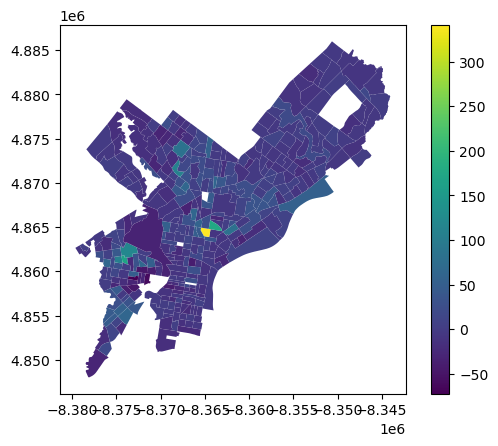

In [94]:
map_data.plot(
    column="percent error", 
    cmap="viridis",
    legend=True)
    

In [72]:
#import hvplot.pandas
choro = map_data.hvplot(
    c="percent error", 
    frame_width=600,
    frame_height=600,
    alpha=0.5,
    cmap="plasma",
    geo=True, 
    tiles='CartoLight')

choro

/Users/hangzhao/mambaforge/envs/musa-550-fall-2023/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/hangzhao/mambaforge/envs/musa-550-fall-2023/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/hangzhao/mambaforge/envs/musa-550-fall-2023/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/hangzhao/mambaforge/envs/musa-550-fall-2023/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/hangzhao/mambaforge/envs/musa-550-fall-2023/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


:Overlay
   .Tiles.I    :Tiles   [x,y]
   .Polygons.I :Polygons   [Longitude,Latitude]   (percent error)

### 2.9 Compare the percent errors in Qualifying Census Tracts and other tracts 

[Qualifying Census Tracts](https://www.huduser.gov/portal/datasets/qct.html) are a poverty designation that HUD uses to allocate housing tax credits

- I've included a list of the census tract names that qualify in Philadelphia
- Add a new column to your dataframe of test set sales that is True/False depending on if the tract is a QCT
- Then, group by this new column and calculate the median percent error

**You should find that the algorithm's accuracy is significantly worse in these low-income, qualifying census tracts**

In [67]:
qct = ['5',
 '20',
 '22',
 '28.01',
 '30.01',
 '30.02',
 '31',
 '32',
 '33',
 '36',
 '37.01',
 '37.02',
 '39.01',
 '41.01',
 '41.02',
 '56',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '69',
 '70',
 '71.01',
 '71.02',
 '72',
 '73',
 '74',
 '77',
 '78',
 '80',
 '81.01',
 '81.02',
 '82',
 '83.01',
 '83.02',
 '84',
 '85',
 '86.01',
 '86.02',
 '87.01',
 '87.02',
 '88.01',
 '88.02',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '96',
 '98.01',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '111',
 '112',
 '113',
 '119',
 '121',
 '122.01',
 '122.03',
 '131',
 '132',
 '137',
 '138',
 '139',
 '140',
 '141',
 '144',
 '145',
 '146',
 '147',
 '148',
 '149',
 '151.01',
 '151.02',
 '152',
 '153',
 '156',
 '157',
 '161',
 '162',
 '163',
 '164',
 '165',
 '167.01',
 '167.02',
 '168',
 '169.01',
 '169.02',
 '170',
 '171',
 '172.01',
 '172.02',
 '173',
 '174',
 '175',
 '176.01',
 '176.02',
 '177.01',
 '177.02',
 '178',
 '179',
 '180.02',
 '188',
 '190',
 '191',
 '192',
 '195.01',
 '195.02',
 '197',
 '198',
 '199',
 '200',
 '201.01',
 '201.02',
 '202',
 '203',
 '204',
 '205',
 '206',
 '208',
 '239',
 '240',
 '241',
 '242',
 '243',
 '244',
 '245',
 '246',
 '247',
 '249',
 '252',
 '253',
 '265',
 '267',
 '268',
 '271',
 '274.01',
 '274.02',
 '275',
 '276',
 '277',
 '278',
 '279.01',
 '279.02',
 '280',
 '281',
 '282',
 '283',
 '284',
 '285',
 '286',
 '287',
 '288',
 '289.01',
 '289.02',
 '290',
 '291',
 '293',
 '294',
 '298',
 '299',
 '300',
 '301',
 '302',
 '305.01',
 '305.02',
 '309',
 '311.01',
 '312',
 '313',
 '314.01',
 '314.02',
 '316',
 '318',
 '319',
 '321',
 '325',
 '329',
 '330',
 '337.01',
 '345.01',
 '357.01',
 '376',
 '377',
 '380',
 '381',
 '382',
 '383',
 '389',
 '390']

In [68]:
merged['qct'] = merged['NAME10'].isin(qct)
merged.head(n=5)

,geometry,cartodb_id_left,assessment_date,basements,beginning_point,book_and_page,building_code,building_code_description,category_code,category_code_description,census_tract,central_air,cross_reference,date_exterior_condition,depth,exempt_building,exempt_land,exterior_condition,fireplaces,frontage,fuel,garage_spaces,garage_type,general_construction,geographic_ward,homestead_exemption,house_extension,house_number,interior_condition,location,mailing_address_1,mailing_address_2,mailing_care_of,mailing_city_state,mailing_street,mailing_zip,market_value,market_value_date,number_of_bathrooms,number_of_bedrooms,number_of_rooms,number_stories,off_street_open,other_building,owner_1,owner_2,parcel_number,parcel_shape,quality_grade,recording_date,registry_number,sale_date,sale_price,separate_utilities,sewer,site_type,state_code,street_code,street_designation,street_direction,street_name,suffix,taxable_building,taxable_land,topography,total_area,total_livable_area,type_heater,unfinished,unit,utility,view_type,year_built,year_built_estimate,zip_code,zoning,pin,building_code_new,building_code_description_new,objectid,name,listname,mapname,shape_leng,shape_area,cartodb_id_right,created_at,updated_at,index_right,OBJECTID,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,LOGRECNO,percent error,qct
5300,POINT (-75.25152 40.04542),23579,2022-05-24T00:00:00Z,A,"429'5 1/2""NW SHAWMONT",54098598,A21,DET 1.5 STY MASONRY+OTHER,1,SINGLE FAMILY,219,Y,None,None,98.0,80000.0,0.0,3,1.0,78.0,None,0.0,None,E,21,0,None,7848,3,7848 NIXON ST,MCDAY JOHN B,None,None,VILLANOVA PA,2058 MATSONS CIR,19085,294100,None,2.0,3.0,NaN,2.0,6204.0,None,MCDAY JOHN B,MCDAY JANE A,212412910,E,C+,2022-09-16T00:00:00Z,150N210094,2022-09-07T00:00:00Z,450000,None,None,None,PA,59920,ST,None,NIXON,None,155300.0,58800.0,F,7594.0,1595.0,B,None,None,None,B,1975,Y,19128,RSA3,1001390664,05,None,401696756,UPPER_ROXBOROUGH,Upper Roxborough,Upper Roxborough,50882.081408,6.869143e+07,46.0,2013-03-19 17:41:50.508000+00:00,2013-03-19 17:41:50.743000+00:00,250.0,251.0,42,101,021900,42101021900,219,Census Tract 219,G5020,S,1410069.0,51091.0,+40.0505829,-075.2470033,10545,-13.025614,False
12908,POINT (-75.12923 40.03141),33061,2022-05-24T00:00:00Z,F,"122'9"" W OF 3RD ST",54061847,R30,ROW B/GAR 2 STY MASONRY,1,SINGLE FAMILY,286,N,None,None,75.0,0.0,0.0,4,0.0,15.0,None,1.0,None,A,42,0,None,316,4,316 W FISHER AVE,ELIAS MUNEER,None,None,PHILADELPHIA PA,454 DELMAR,19128,107800,None,1.0,3.0,NaN,2.0,1942.0,None,ELIAS MUNEER,None,422248000,E,C,2022-06-27T00:00:00Z,123N12 229,2022-06-24T00:00:00Z,83139,None,None,None,PA,34140,AVE,W,FISHER,None,86240.0,21560.0,F,1144.0,1290.0,H,None,None,None,I,1930,Y,19120,RSA5,1001214868,24,ROW PORCH FRONT,401704506,OLNEY,Olney,Olney,32197.205271,5.030840e+07,8.0,2013-03-19 17:41:50.508000+00:00,2013-03-19 17:41:50.743000+00:00,108.0,109.0,42,101,028600,42101028600,286,Census Tract 286,G5020,S,717845.0,0.0,+40.0285757,-075.1276448,10600,27.456476,True
20713,POINT (-75.20568 40.02309),43246,2022-05-24T00:00:00Z,E,126'N OF SALAIGNAC ST,54006879,R30,ROW B/GAR 2 STY MASONRY,1,SINGLE FAMILY,211,Y,None,None,100.0,0.0,0.0,4,0.0,16.0,None,1.0,None,E,21,0,None,5455,4,5455 VICARIS ST,SIMPLIFILE LC E-RECORDING,None,None,PHILADELPHIA PA,5455 VICARIS ST,19128-2826,245400,None,1.0,3.0,NaN,2.0,2941.0,None,HOOKS SHEENA,None,213221174,E,C,2022-03-24T00:00:00Z,96N12 85,2022-03-04T00:00:00Z,250000,None,None,None,PA,80000,ST,None,VICARIS,None,196320.0,49080.0,F,1600.0,1110.0,A,None,None,None,I,1965,Y,19128,RSA5,1001540422,23,ROW POST WAR,401715911,WISSAHICKON,Wissahickon,Wissahickon,17714.185972,9.064239e+06,53.0,2013-03-19 17:41:50.508000+00:00,2013-03-19 17:41:50.743000+00:00,85.0,86.0,42,101,021100,42101021100,211,Census Tract 211,G5020,S,540313.0,0.0,+40.0264564,-075.2065293,10537,-7.974018,False
2310,POINT (-75.17142 39.93675),19863,2022-05-24T00:00:00Z,None,"261'6"" W 16TH ST",54118070,O30,ROW 2 STY MASONRY,1,SINGLE FAM

In [69]:
new_data = merged.groupby("qct", as_index=False)["percent error"].median()

In [70]:
new_data

,qct,percent error
0,False,-6.104082
1,True,2.834477


#### Percent error in True areas is positive, which is obviously higher than the False areas. It is true that algorithm’s accuracy is significantly worse in these low-income, qualifying census tracts